# SIC PROJECT


Import the dependencies and set the device


In [ ]:
# requirements and dependencies
# check if the requirements are installed
requirements = [
    "tensorflow",
    "numpy",
    "matplotlib",
    "tensorboard",
    "tensorflow_hub",
    "sklearn",
]
# if not, quit
for requirement in requirements:
    try:
        __import__(requirement)
    except ImportError:
        print("one or more requirements are not installed")
        print("please install the requirements in the requirements.txt file")
        print("you can do this by running the following command in the terminal:")
        print("pip install -r requirements.txt")
        raise ImportError("Requirement not installed: {}".format(requirement))

print("All requirements are installed, you are good to go!")

All requirements are installed, you are good to go!


In [10]:
#import packages
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns



%load_ext tensorboard
print("success")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
success


In [4]:
# check devices available
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.config.list_physical_devices()

/device:GPU:0
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Exploring and Processing


- Reading, processing, and augmenting all done by `ImageDataGenerator`


**Rapid EDA**


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator()
train_ds = datagen.flow_from_directory("data/train")
print("classes: ", train_ds.class_indices)
imgs, labels = train_ds.next()

Found 2295 images belonging to 3 classes.
classes:  {'Fire': 0, 'Neutral': 1, 'Smoke': 2}


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


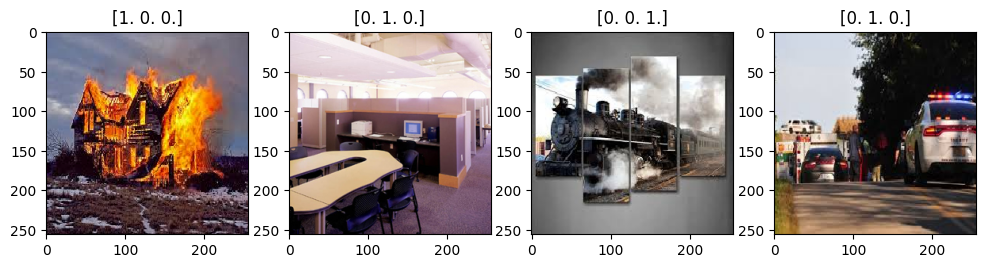

In [ ]:
# display random images from the dataset
fig, ax = plt.subplots(1, 4, figsize=(12, 9))
for i in range(4):
    idx = np.random.randint(0, len(imgs))
    ax[i].imshow(imgs[idx].astype("uint8"))
    ax[i].set_title(labels[idx])

**Processing and Augmenting Data**


In [6]:
# only augmenting the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=10.0,
    height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True,
)

test_val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_ds = train_datagen.flow_from_directory("data/train", target_size=(224, 224),seed=42)
val_ds = test_val_datagen.flow_from_directory("data/val", target_size=(224, 224), seed=42)
test_ds = test_val_datagen.flow_from_directory("data/test", target_size=(224, 224),seed=42)

Found 2295 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


# Models building


In [7]:
# built from scratch model
def get_builtFromScartchModel(
    IMG_SIZE=224, NUM_CLASSES=3, dropout_rate=0.2, lr=0.001, act="relu"
):
    """
    A function to build a model from scratch

    Args:
        IMG_SIZE (int, optional): Image size. Defaults to 224.
        NUM_CLASSES (int, optional): Number of classes. Defaults to 3.
        dropout_rate (float, optional): Dropout rate. Defaults to 0.2.
        lr (float, optional): Learning rate. Defaults to 0.001.
        act (str, optional): Activation function for middle layers. Defaults to "relu".

    Returns:
        model: A compiled model built from scratch
    """
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                128, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)
            ),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation=act),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Conv2D(32, (3, 3), activation=act),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation=act),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(48, activation=act),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(32, activation=act),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    # get model summary
    model.summary()

    return model

In [8]:
def get_trained_model(url, inputShape=(224, 224, 3), trainModel=True, lr=0.001,inner_units=64,dropout_rate=0.2):
    """
    A function to get a trained model from a url

    Args:
        url (str): url of the model
        inputShape (tuple, optional): input shape of the model. Defaults to (224, 224, 3).
        trainModel (bool, optional): whether to train the model. Defaults to False.
        lr (float, optional): learning rate of the model. Defaults to 0.001.

    Returns:
        model: a trained model
    """
    feature_extractor_layer = hub.KerasLayer(
        url, input_shape=inputShape, trainable=trainModel
    )

    model = tf.keras.Sequential(
        [
            feature_extractor_layer,
            tf.keras.layers.Dense(inner_units, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(3, activation="softmax"),  # smoke, normal, fire
        ]
    )

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )

    # display the model summary
    model.summary()

    return model

# Train & Hyperparameter tuning


**1.0 Build multiple `FromScratch Model` with different hyperparameters**


In [ ]:
# load model
model = get_builtFromScartchModel(act="leaky_relu")

# some parameters
EPOCHS = 10
IMG_SIZE = 224
BATCH_SIZE = 32

# for tensorboard
log_dir = (
    "logs/fit/" + str(len(os.listdir("logs/fit")) + 1)
    if os.path.exists("logs/fit")
    else "logs/fit/1"
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with tf.device("/device:GPU:0"):
    historyFit = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[tensorboard_callback],
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        1

In [ ]:
evaluate(model, historyFit, test_ds)

10/10 [==============================] - 1s 109ms/step
--------------------------------------------------
Test Accuracy: 0.8133333333333334
----------
while fitting the model, the accuracy was: 
0.7904139161109924 in the train data
0.8024691343307495 in the validation data
--------------------------------------------------
Confusion matrix:
[[91  3  6]
 [13 65 22]
 [ 4  8 88]]
--------------------------------------------------
Classification report:
              precision    recall  f1-score   support

        Fire       0.84      0.91      0.87       100
     Neutral       0.86      0.65      0.74       100
       Smoke       0.76      0.88      0.81       100

    accuracy                           0.81       300
   macro avg       0.82      0.81      0.81       300
weighted avg       0.82      0.81      0.81       300



<ipython-input-19-696f0ea3245a>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


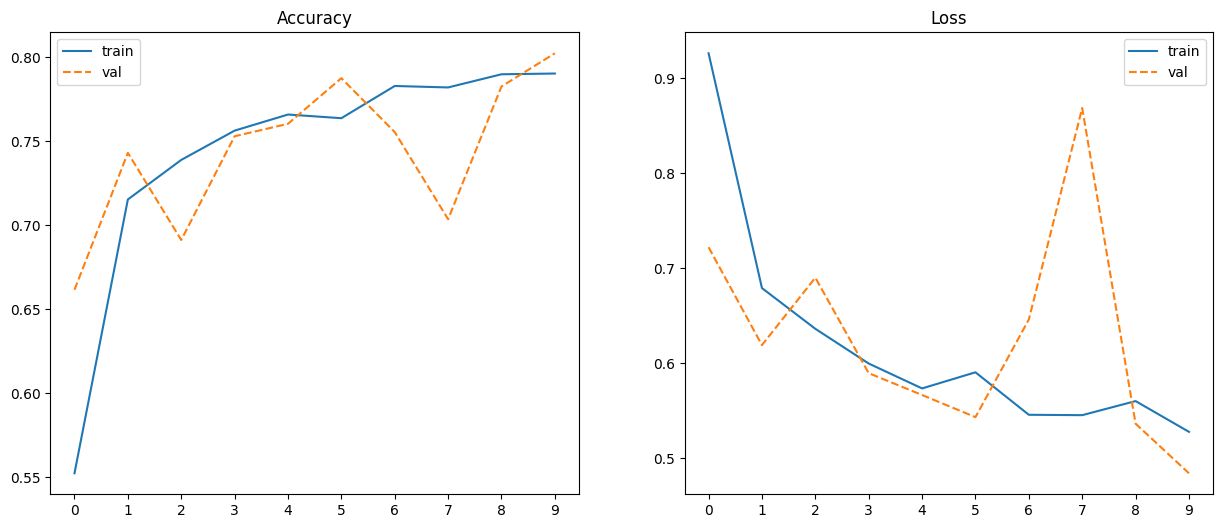

In [ ]:
plt.subplots(figsize=(15,6))
#accuracy
plt.subplot(1,2,1)
plt.plot(historyFit.history["categorical_accuracy"], label="train")
plt.plot(historyFit.history["val_categorical_accuracy"], label="val",linestyle='dashed')
plt.xticks(np.arange(10))
plt.title("Accuracy")
plt.legend()
#loss
plt.subplot(1,2,2)
plt.plot(historyFit.history["loss"], label="train")
plt.plot(historyFit.history["val_loss"], label="val",linestyle='dashed')
plt.xticks(np.arange(10))
plt.title("Loss")
plt.legend()

plt.show()

**1.1 Search for Best Learning rate**


In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = get_builtFromScartchModel(lr=lr)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[lr] = history.history

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 54, 54, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 52, 52, 32)       

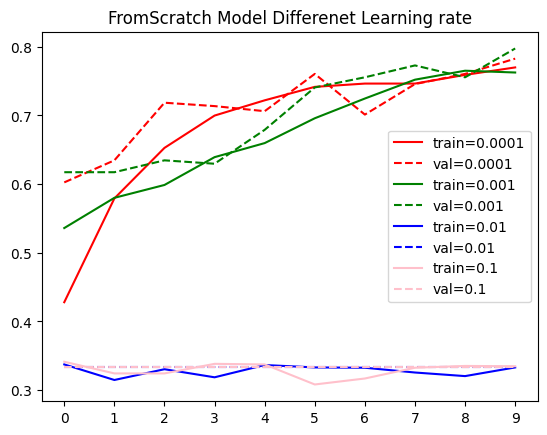

In [ ]:
colors = ["red", "green", "blue","pink"]
for i,(lr, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"),color=colors[i])
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"),linestyle='dashed',color=colors[i])

plt.xticks(np.arange(10))
plt.legend()
plt.title('FromScratch Model Differenet Learning rate')
plt.show()

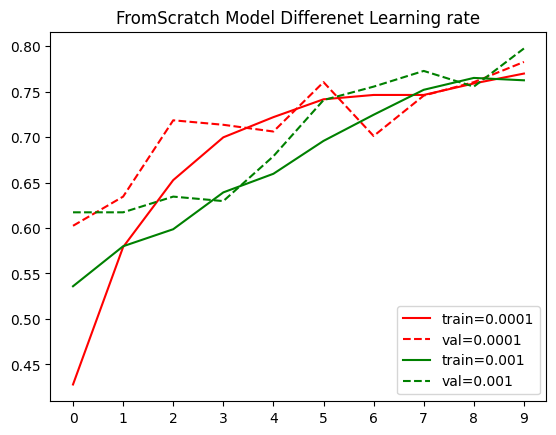

In [ ]:
# remove poor scores to see better
del scores[0.1]
del scores[0.01]

for i,(lr, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"),color=colors[i])
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"),linestyle='dashed',color=colors[i])

plt.xticks(np.arange(10))
plt.legend()
plt.title('FromScratch Model Differenet Learning rate')
plt.show()

**1.2 Search for best dropout rate**


In [ ]:
FromScratch={} #stores the best hyperparamter for FromScratchModel
FromScratch["learning_rate"] = 0.001  # best lr so far
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    model = get_builtFromScartchModel(lr=FromScratch["learning_rate"], dropout_rate=droprate)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[droprate] = history.history

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 54, 54, 64)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 32)      

Text(0.5, 1.0, 'FromScratch Model Differenet dropout rate')

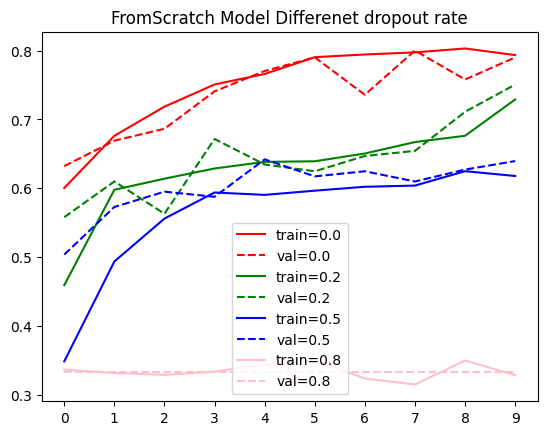

In [ ]:
for i,(droprate, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={droprate}"),color=colors[i])
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={droprate}"),linestyle='dashed',color=colors[i])

plt.xticks(np.arange(10))
plt.legend()
plt.title('FromScratch Model Differenet dropout rate')

In [ ]:
FromScratch["droprate"]=0.0
print('Best Hyperparamters for FromScratchModel:\n',FromScratch)

Best Hyperparamters for FromScratchModel:
 {'learning_rate': 0.001, 'droprate': 0.0}


**2.0 Build multiple `Pre-trained Model (EfficientNetv2)` with different hyperparameters**


In [ ]:
# Load the EfficientNetV2 pre-trained model from TensorFlow Hub, recommended input size is 240x240 pixels
module_url = (
    "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2"
)
model = get_trained_model(module_url)

# for tensorboard
log_dir = (
    "logs/fit/" + str(len(os.listdir("logs/eval")) + 1)
    if os.path.exists("logs/eval")
    else "logs/eval/1"
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# some parameters
EPOCHS = 15
BATCH_SIZE = 32

with tf.device("/device:GPU:0"):
    historyFit = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[tensorboard_callback],
        batch_size=BATCH_SIZE,
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              8212124   
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 8,276,383
Trainable params: 8,205,311
Non-trainable params: 71,072
_________________________________________________________________
Epoch 1/15
72/72 [==============================] - 1350s 18s/step - loss: 0.4040 - categorical_accuracy: 0.8662 - val_loss: 0.2870 - val_categorical_accuracy: 0.9284
Epoch 

<ipython-input-13-c42840df9fc6>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


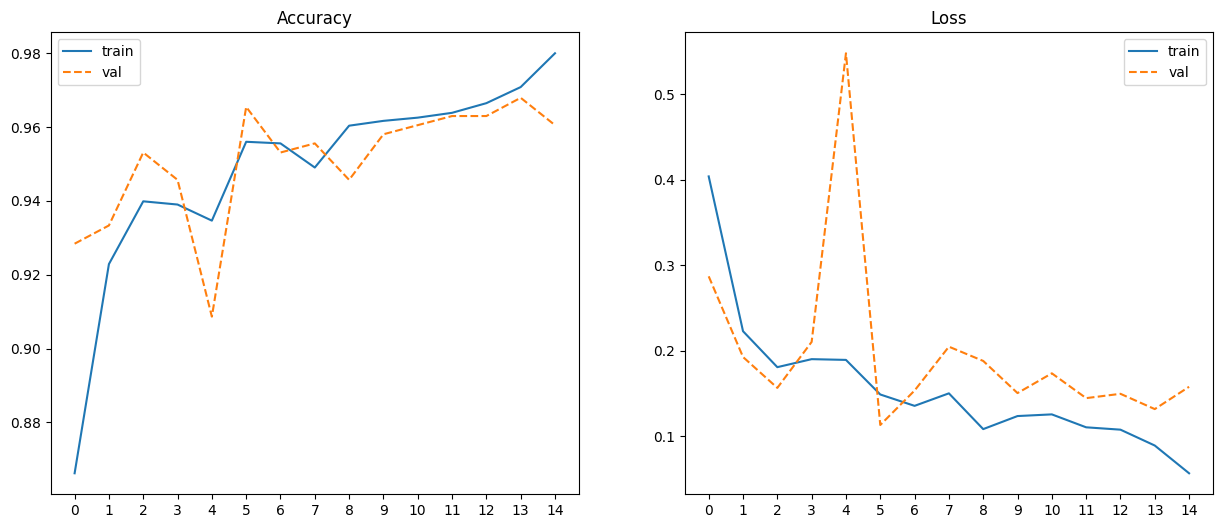

In [ ]:
plt.subplots(figsize=(15,6))
#accuracy
plt.subplot(1,2,1)
plt.plot(historyFit.history["categorical_accuracy"], label="train")
plt.plot(historyFit.history["val_categorical_accuracy"], label="val",linestyle='dashed')
plt.xticks(np.arange(15))
plt.title("Accuracy")
plt.legend()
#loss
plt.subplot(1,2,2)
plt.plot(historyFit.history["loss"], label="train")
plt.plot(historyFit.history["val_loss"], label="val",linestyle='dashed')
plt.xticks(np.arange(15))
plt.title("Loss")
plt.legend()

plt.show()

**2.1 Search for Best Learning rate**

In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = get_trained_model(module_url,lr=lr)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[lr] = history.history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1000)              8212124   
                                                                 
 dense_2 (Dense)             (None, 64)                64064     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 8,276,383
Trainable params: 8,205,311
Non-trainable params: 71,072
_________________________________________________________________
Epoch 1/15
72/72 [==============================] - 46s 459ms/step - loss: 0.6138 - categorical_accuracy: 0.7412 - val_loss: 0.2185 - val_categorical_accuracy: 0.9358
Epoc

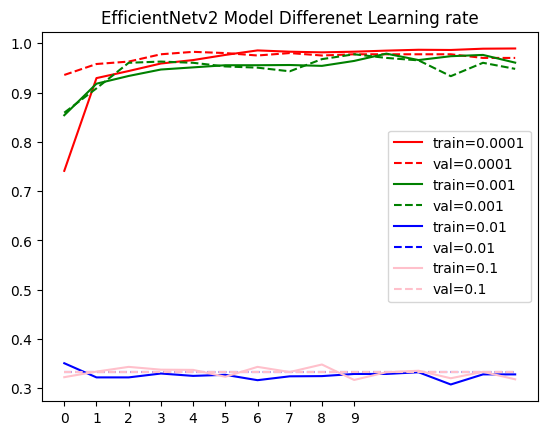

In [ ]:
colors = ["red", "green", "blue","pink"]
for i,(lr, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"),color=colors[i])
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"),linestyle='dashed',color=colors[i])

plt.xticks(np.arange(10))
plt.legend()
plt.title('EfficientNetv2 Model Differenet Learning rate')
plt.show()

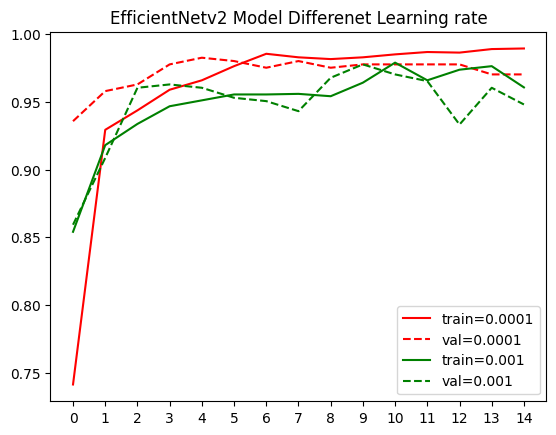

In [ ]:
del scores[0.01]
del scores[0.1]

for i,(lr, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"),color=colors[i])
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"),linestyle='dashed',color=colors[i])

plt.xticks(np.arange(15))
plt.legend()
plt.title('EfficientNetv2 Model Differenet Learning rate')
plt.show()

**2.2 Search for the best number of hidden units in the inner `Dense Layer`**

In [ ]:
EfficientNet={}
EfficientNet["learning_rate"]=0.0001 #best lr value

scores = {}

for size in [48, 128, 256]:
    model = get_trained_model(module_url,lr=EfficientNet["learning_rate"],inner_units=size)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[size] = history.history

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1000)              8212124   
                                                                 
 dense_16 (Dense)            (None, 48)                48048     
                                                                 
 dropout_8 (Dropout)         (None, 48)                0         
                                                                 
 dense_17 (Dense)            (None, 3)                 147       
                                                                 
Total params: 8,260,319
Trainable params: 8,189,247
Non-trainable params: 71,072
_________________________________________________________________
Epoch 1/15
72/72 [==============================] - 49s 460ms/step - loss: 0.5910 - categorical_accuracy: 0.7547 - val_loss: 0.2493 - val_categorical_accuracy: 0.9284
Epoc

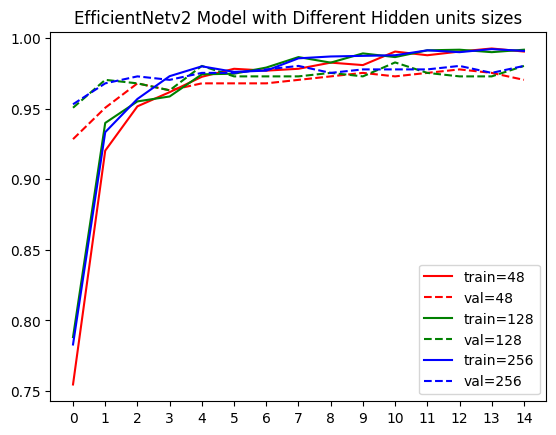

In [ ]:
for i,(size, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={size}"),color=colors[i])
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={size}"),linestyle='dashed',color=colors[i])

plt.xticks(np.arange(15))
plt.legend()
plt.title('EfficientNetv2 Model with Different Hidden units sizes')
plt.show()

**2.3 Search For Best droprate**

In [ ]:
EfficientNet["size"] = 256  # best size so far
scores = {}

for droprate in [0.0, 0.1, 0.2, 0.5]:
    model = get_trained_model(module_url,lr=EfficientNet["learning_rate"],inner_units=EfficientNet["size"],dropout_rate=droprate)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[droprate] = history.history

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_11 (KerasLayer)  (None, 1000)             8212124   
                                                                 
 dense_22 (Dense)            (None, 256)               256256    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 3)                 771       
                                                                 
Total params: 8,469,151
Trainable params: 8,398,079
Non-trainable params: 71,072
_________________________________________________________________
Epoch 1/15
72/72 [==============================] - 46s 467ms/step - loss: 0.4458 - categorical_accuracy: 0.8205 - val_loss: 0.1915 - val_categorical_accuracy: 0.9333
Epo

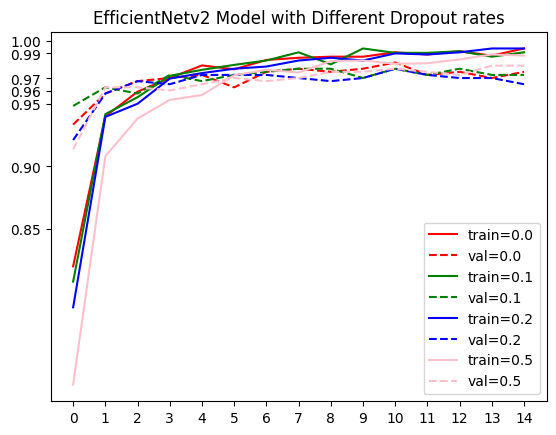

In [ ]:
for i,(droprate, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={droprate}"),color=colors[i])
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={droprate}"),linestyle='dashed',color=colors[i])

plt.xticks(np.arange(15))
plt.yticks([0.85,0.9,0.95,0.96,0.97,0.99,1.0])
plt.legend()
plt.title('EfficientNetv2 Model with Different Dropout rates')
plt.show()

In [ ]:
EfficientNet["droprate"] = 0.1  # best size so
print("Best Hyperparameter values for EfficientNetv2:\n",EfficientNet)

Best Hyperparameter values for EfficientNetv2:
 {'learning_rate': 0.0001, 'size': 256, 'droprate': 0.1}


In [9]:
FromScratch={'learning_rate': 0.001, 'droprate': 0.0}
EfficientNet={'learning_rate': 0.0001, 'size': 256, 'droprate': 0.1}

# Models Evalution

In [24]:
def evaluate(model, fitHistory, test_data):
    """
    Test the model on the test data and print the accuracy, confusion matrix and classification report.

    Args:
        model: A Keras model.
        fitHistory: A Keras History object returned by the `fit` method.
        test_data: A keras dataset object.

    """
    # convert test_data to numpy array
    y = np.concatenate([test_data.next()[1] for i in range(test_data.__len__())])

    # predict
    predictions = model.predict(test_data)
    predictions = np.argmax(predictions, axis=1)
    test_labels = np.argmax(y, axis=1)
    print("-" * 50)
    # print accuracy
    print(
        "Test Accuracy: "
        + str(accuracy_score(test_labels, predictions))
        + "\n"
        + "-" * 10
        + "\n"
        + "while fitting the model, the accuracy was: \n"
        + str(fitHistory.history["categorical_accuracy"][-1])
        + " in the train data"
        + "\n"
        + str(fitHistory.history["val_categorical_accuracy"][-1])
        + " in the validation data"
    )
    print("-" * 50)
    # print classification report
    print(
        "Classification report:\n"
        + str(
            classification_report(
                test_labels, predictions, target_names=["Fire", "Neutral", "Smoke"]
            )
        )
    )
    # print confusion matrix
    print("-" * 50)
    labels=["Fire","Neutral","Smoke"]
    print("Confusion matrix:\n", sns.heatmap(confusion_matrix(test_labels, predictions),annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues'))

In [14]:
EPOCHS=15
BATCH_SIZE=32
FromScratchModel=get_builtFromScartchModel(dropout_rate=FromScratch["droprate"],lr=FromScratch["learning_rate"])
EfficientNetModel=get_trained_model(module_url,dropout_rate=EfficientNet["droprate"],lr=EfficientNet["learning_rate"],inner_units=EfficientNet["size"])

FromScratch_history=FromScratchModel.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=0)
EfficientNet_history=EfficientNetModel.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 54, 54, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 32)       

FromScratchModel Evaluation
10/10 [==============================] - 1s 97ms/step
--------------------------------------------------
Test Accuracy: 0.74
----------
while fitting the model, the accuracy was: 
0.8488017320632935 in the train data
0.8049382567405701 in the validation data
--------------------------------------------------
Classification report:
              precision    recall  f1-score   support

        Fire       0.88      0.83      0.86       100
     Neutral       0.59      0.87      0.70       100
       Smoke       0.88      0.52      0.65       100

    accuracy                           0.74       300
   macro avg       0.79      0.74      0.74       300
weighted avg       0.79      0.74      0.74       300

--------------------------------------------------
Confusion matrix:
 Axes(0.125,0.11;0.62x0.77)


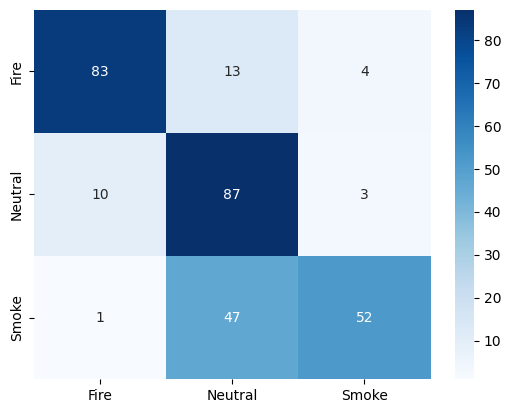

In [25]:
print("FromScratchModel Evaluation")
evaluate(FromScratchModel, FromScratch_history, test_ds)

EfficientNetModel Evaluation
10/10 [==============================] - 1s 107ms/step
--------------------------------------------------
Test Accuracy: 0.9633333333333334
----------
while fitting the model, the accuracy was: 
0.9925925731658936 in the train data
0.9728395342826843 in the validation data
--------------------------------------------------
Classification report:
              precision    recall  f1-score   support

        Fire       0.97      0.92      0.94       100
     Neutral       0.99      0.99      0.99       100
       Smoke       0.93      0.98      0.96       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

--------------------------------------------------
Confusion matrix:
 Axes(0.125,0.11;0.62x0.77)


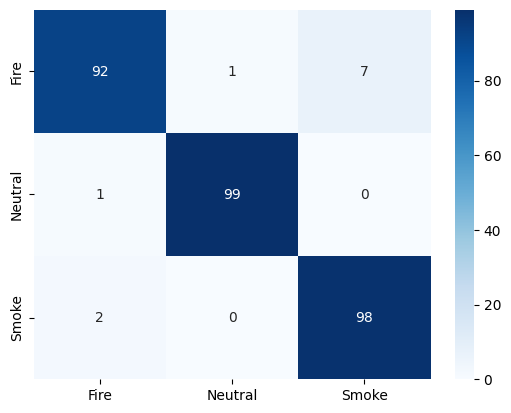

In [26]:
print("EfficientNetModel Evaluation")
evaluate(EfficientNetModel,EfficientNet_history,test_ds)

In [27]:
# ask the user which model to save?
n = input("Which model do you want to save? (1/2)\n \
1-EfficientNetv2Model\n \
2-FromScratchModel \n")
if n == "1":
    EfficientNetModel.save("Models/preTrainedModel.h5")
    print("EfficientNetv2 were saved")
elif n == "2":
    FromScratchModel.save("Models/FromScratchModel.h5")
    print("FromScratchModel were saved")
else:
    print("Model not saved")

Which model do you want to save? (1/2)
 1-EfficientNetv2Model
 2-FromScratchModel 
1
EfficientNetv2 were saved


In [ ]:
#lunch tensorboard to plot the results and the graphs
%tensorboard --logdir logs --port=6910